# Switching from moist to dry adiabat <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we consider the problem of switcing from a moist to a dry adiabat when the parcel evaporates all its liquid water during descent.

In [192]:
import metpy.constants as const
import metpy.calc as mpcalc
from metpy.units import units

import matplotlib.pyplot as plt

import numpy as np
from scipy.misc import derivative
from scipy.optimize import root_scalar

import sys
sys.path.append('../../scripts/')
from thermo import moist_lapse

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Theory" data-toc-modified-id="Theory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Theory</a></span><ul class="toc-item"><li><span><a href="#Finding-$\partial-\theta_E-/-\partial-T'$" data-toc-modified-id="Finding-$\partial-\theta_E-/-\partial-T'$-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Finding $\partial \theta_E / \partial T'$</a></span></li><li><span><a href="#Checking-the-$\partial-\theta_E-/-\partial-T'$-function" data-toc-modified-id="Checking-the-$\partial-\theta_E-/-\partial-T'$-function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Checking the $\partial \theta_E / \partial T'$ function</a></span></li></ul></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

## Theory

Suppose we have a parcel at pressure $p$, with temperature $T$, specific humidity $q$ and liquid ratio $l$. We want to know the resulting values $T'$, $q'$ and $l'$ after the parcel descends to a pressure $p' > p$.

**Case 1:** $l=0$.  
The descent will be entirely dry adiabatic.

**Case 2:** $l>0$.  
The descent will be at least partly moist adiabatic.  
We first try descending moist adiabatically to $p'$; this gives a tentative value of $T'$. Since the parcel stays saturated, we will have $q' = q^*(p', T')$. From conservation of liquid mass, $l' = q' + l' - q''$.

> **Case 2.1:** $l' = q' + l' - q'' \ge 0$.  
There is liquid left over, so the descent can be fully moist adiabatic.

> **Case 2.2:** $l' = q' + l' - q'' < 0$.  
Moist descent only would consume more liquid water than is available, so parcel must switch from a moist to a dry adiabat somewhere between $p$ and $p'$.  
<br>
Rather than explicitly calculating the switching point, which is computationally costly, we will use conservation of equivalent potential temperature to calculate $T'$ indirectly. Specifically, the final state should satisfy
$$\theta_E(p', T', q') = \theta_E(p, T, q).$$
Since all liquid water has been consumed ($l'=0$), we know that $q' = q + l$ so our condition is reduced to
$$\theta_E(p', T', q + l) = \theta_E(p, T, q), \hspace{2cm} (*)$$
a single equation in a single unknown, $T'$. We can solve it numerically using Newton's method.

### Finding $\partial \theta_E / \partial T'$
In order to apply Newton's method to $(*)$, we need to know $\partial \theta_E / \partial T'$.
We use the approximate expression for $\theta_E$ given in *Bolton (1980)*:
$$\theta_{E}=\theta_{DL}\exp\left[\left(\frac{3036}{T_{L}}-1.78\right)r(1+0.448r)\right]$$
where $r$ is the mixing ratio and
$$\theta_{DL}=T_{K}\left(\frac{1000}{p-e}\right)^k \left(\frac{T_{K}}{T_{L}}\right)^{0.28r}$$
is the potential temperature at the LCL, where $T_K$ is the absolute temperature and
$$T_{L}=\left( \frac{1}{T_{D}-56}+\frac{ln(T_{K}/T_{D})}{800} \right)^{-1}+56$$
is the temperature at the $LCL$.

We first note that $\partial \theta_E / \partial T' = \theta_E (\partial \log \theta_E / \partial T_K)$, with
$$
    \frac{\partial \log \theta_E}{\partial T_K}
    =  \frac{\partial \log \theta_{DL}}{\partial T_K}
    - \frac{3036}{T_L^2} r (1+0.448r) \frac{\partial T_L}{\partial T_K}.
$$
Now,
$$
\begin{align}
    \frac{\partial \log \theta_{DL}}{\partial T_K}
    &= \frac{1}{T_K} + \frac{0.28r}{T_K} - \frac{0.28r}{T_L} \frac{\partial T_L}{\partial T_K} \\
    &= \frac{1 + 0.28r}{T_K} - \frac{0.28r}{T_L} \frac{\partial T_L}{\partial T_K}
\end{align}
$$
and
$$
    \frac{\partial T_L}{\partial T_K}
    = - \left( \frac{1}{T_D - 56} + \frac{\log T_K - \log T_D}{800} \right)^{-2}
    \left(
        -\frac{1}{(T_D - 56)^2} \frac{\partial T_D}{\partial T_K}
        + \frac{1}{800} \left( \frac{1}{T_K} - \frac{1}{T_D} \frac{\partial T_D}{\partial T_K} \right)
    \right).
$$

Bolton's eq. 10 for the saturation vapour pressure $e_s$ implies that
$$
    T_D = \frac{b \log(Ue_s/e_0)}{a - \log(Ue_s/e_0)} + C
$$
where $U$ is the relative humidity, $a = 17.67$, $b = 243.5$ K, $e_0 = 6.112$ mbar and $C = 273.15$ K. Then
$$
\begin{align}
    \frac{\partial T_D}{\partial T_K}
    &= \frac{(a - \log(Ue_s/e_0)b + b\log(Ue_s/e_0)}{(a - \log(Ue_s/e_0))^2} \frac{\partial \log e_s}{\partial T_K} \\
    &= \frac{ab}{(a - \log(Ue_s/e_0))^2} \frac{\partial \log e_s}{\partial T_K}
\end{align}
$$
Bolton's eq. 10 in its original form gives
$$e_s = e_0 \exp \left( \frac{a(T_K - C)}{T_K - C + b} \right) $$
which implies
$$
    \frac{\partial \log e_s}{\partial T_K} = \frac{ab}{(T_K - C + b)^2}.
$$
Finally, we can also substitute the exact relation
$$
    U = \frac{q}{1-q} \frac{p - e_s}{\epsilon e_s}
$$
where $\epsilon$ is the ratio of the molar mass of dry air to the molar mass of water vapour.

We now work backwards to write a function that calculates $\partial \theta_E / \partial T_K$ given $p$, $T_K$ and $q$.

In [170]:
def theta_e_prime(p, Tk, q):
    """
    Calculates the partial derivative of theta-e w.r.t. temperature.
    
    Uses the approximation of theta-e given in eq. 39 of Bolton (1980).
    
    Args:
        p: Pressure.
        Tk: Temperature.
        q: Specific humidity.
        
    Returns:
        The partial derivative of equivalent potential temperature
            with respect to temperature.
    """
    
    # ensure correct units
    p = p.m_as(units.mbar)
    Tk = Tk.m_as(units.kelvin)
    if hasattr(q, 'units'):
        q = q.m_as(units.dimensionless)
    
    # constants
    a = 17.67  # dimensionless
    b = 243.5  # kelvin
    C = 273.15  # 0C (kelvin)
    e0 = 6.112  # saturation vapour pressure at 0C (mbar)
    epsilon = const.epsilon.m  # molar mass ratio of dry air to water vapour
    kappa = const.kappa.m # poisson constant of dry air
    
    # other variables
    es = e0*np.exp(a*(Tk - C)/(Tk - C + b))  # sat. vapour pressure in mbar
    U = q/(1 - q)*(p - es)/(epsilon*es)  # relative humidity
    e = U*es # vapour pressure in mbar
    Td = b*np.log(U*es/e0)/(a - np.log(U*es/e0)) + C  # dew point in kelvin
    r = q/(1-q)  # mixing ratio
    
    # LCL temperature in kelvin
    Tl = (1/(Td - 56) + np.log(Tk/Td)/800)**(-1) + 56
    # LCL potential temperature in kelvin
    thetadl = Tk*(1000/(p - e))**kappa*(Tk/Tl)**(0.28*r)
    # equivalent potential temperature in kelvin
    thetae = thetadl*np.exp((3036/Tl - 1.78)*r*(1 + 0.448*r))
    
    # derivative of sat. vapour pressure w.r.t. temperature
    dloges_dTk = a*b/(Tk - C + b)**2
    # derivative of dew point w.r.t. temperature
    dTd_dTk = a*b/(a - np.log(U*es/e0))**2 * dloges_dTk
    # derivative of LCL temperature w.r.t. temperature
    dTl_dTk = (-(1/(Td - 56) + np.log(Tk/Td)/800)**(-2)
               *(-1/(Td - 56)**2*dTd_dTk + 1/800*(1/Tk - 1/Td*dTd_dTk)))
    # derivative of log(LCL potential temperature) w.r.t. temperature
    dlogthetadl_dTk = (1 + 0.28*r)/Tk - 0.28*r/Tl*dTl_dTk
    # derivative of log(equivalent potential temperature) w.r.t. temperature
    dlogthetae_dTk = dlogthetadl_dTk - 3036/Tl**2*r*(1 + 0.448*r)*dTl_dTk
    
    return thetae*dlogthetae_dTk

### Checking the $\partial \theta_E / \partial T'$ function

We test the function we have written against a finite difference approximation of the derivative.

In [179]:
def thetae(T):
    dewpoint = mpcalc.dewpoint_from_specific_humidity(
        700*units.mbar, T*units.kelvin, 1e-3)
    return mpcalc.equivalent_potential_temperature(
        700*units.mbar, T*units.kelvin, dewpoint).m_as(units.kelvin)

temperature = np.arange(-15+273.15, 20+273.15)

In [180]:
%%time
diff_metpy = np.array([
    derivative(thetae, T, dx=0.001, order=5)
    for T in temperature
])

CPU times: user 748 ms, sys: 6.37 ms, total: 754 ms
Wall time: 755 ms


In [181]:
%%time
diff_new_exact = np.array([
    theta_e_prime(700*units.mbar, T*units.kelvin, 1e-3)
    for T in temperature
])

CPU times: user 20.5 ms, sys: 1.08 ms, total: 21.6 ms
Wall time: 20.9 ms


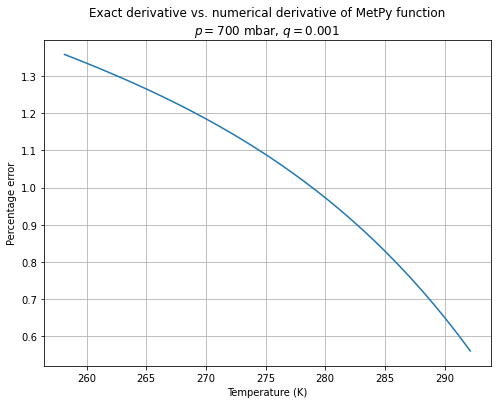

In [187]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(temperature, (diff_metpy - diff_new_exact)/diff_metpy*100)
ax.grid()
ax.set(
    xlabel='Temperature (K)',
    ylabel='Percentage error',
    title=r'Exact derivative vs. numerical derivative of MetPy function'
        '\n$p = 700$ mbar, $q = 0.001$')
plt.show()

## Implementation

In [200]:
def saturation_specific_humidity(pressure, temperature):
    return mpcalc.specific_humidity_from_mixing_ratio(
        mpcalc.saturation_mixing_ratio(pressure, temperature))

def theta_e(pressure, temperature, specific_humidity):
    dewpoint = mpcalc.dewpoint_from_specific_humidity(
        pressure, temperature, specific_humidity)
    return mpcalc.equivalent_potential_temperature(
        pressure, temperature, dewpoint)

In [201]:
def descend(
        pressure, temperature, specific_humidity, liquid_ratio,
        reference_pressure, improve=1):
    """
    Calculates the temperature of a descending parcel.
    
    Uses conservation of equivalent potential temperature to determine
    the final temperature if the parcel switches from a moist to a dry
    adiabat.
    
    Args:
        pressure: Final pressure.
        temperature: Initial temperature.
        specific_humidity: Initial specific humidity.
        liquid_ratio: Initial liquid ratio.
        reference_pressure: Initial pressure.
        improve: Number of iterations to use if the parcel must switch
            from moist to dry adiabat (default: 1). Alternatively,
            specify False to skip iteration and take the moist
            adiabatic value, or 'exact' to iterate until convergence.
            
    Returns:
        Final temperature, specific humidity and liquid ratio.
    """
    
    if liquid_ratio <= 0:
        # case 1: dry adiabat only
        t_final = mpcalc.dry_lapse(pressure, temperature, reference_pressure)
        q_final = q_initial
        l_final = 0*units.dimensionless
        return t_final, q_final, l_final
    else:
        # case 2: some moist descent
        t_final_guess = moist_lapse(pressure, temperature, reference_pressure)
        q_final_guess = saturation_specific_humidity(pressure, t_final)
        l_final_guess = specific_humidity + liquid_ratio - q_final
        if l_final >= 0 or improve is False:
            # case 2.1: moist adiabat only
            return t_final_guess, q_final_guess, l_final_guess
        else:
            # case 2.2: adiabat switching
            q_final = specific_humidity + liquid_ratio
            l_final = 0*units.dimensionless
            
            theta_e_initial = theta_e(
                reference_pressure, temperature,
                specific_humidity).m_as(units.kelvin)
            theta_e_difference = lambda T: (
                theta_e(pressure, T*units.kelvin, q_final).m_as(units.kelvin)
                - theta_e_initial)
            theta_e_difference_prime = lambda T: (
                theta_e_prime(pressure, T*units.kelvin, q_final))
            if improve == 'exact':
                # iterate until convergence using Newton's method
                sol = root_scalar(
                    theta_e_difference, x0=t_final_guess.m_as(units.kelvin),
                    fprime=theta_e_difference_prime, method='newton')
                t_final = sol.root*units.kelvin
            else:
                # apply a fixed number of iterations
                t_final = t_final_guess.m_as(units.kelvin)
                for i in range(improve):
                    t_final = (t_final - theta_e_difference(t_final)
                               / theta_e_difference_prime(t_final))
                t_final = t_final*units.kelvin
            
            return t_final, q_final, l_final

## Testing